In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Load and explore one of the CSV files to understand the structure
data_path = Path("../data/source")
csv_files = list(data_path.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"  - {file.name}")

# Load the first file to examine structure
if csv_files:
    sample_df = pd.read_csv(csv_files[0])
    print(f"\nSample dataset shape: {sample_df.shape}")
    print(f"\nColumns: {list(sample_df.columns)}")
    print(f"\nFirst few rows:")
    print(sample_df.head())

Found 12 CSV files:
  - 2022_LoL_esports_match_data_from_OraclesElixir.csv
  - 2016_LoL_esports_match_data_from_OraclesElixir.csv
  - 2023_LoL_esports_match_data_from_OraclesElixir.csv
  - 2017_LoL_esports_match_data_from_OraclesElixir.csv
  - 2015_LoL_esports_match_data_from_OraclesElixir.csv
  - 2021_LoL_esports_match_data_from_OraclesElixir.csv
  - 2024_LoL_esports_match_data_from_OraclesElixir.csv
  - 2020_LoL_esports_match_data_from_OraclesElixir.csv
  - 2025_LoL_esports_match_data_from_OraclesElixir.csv
  - 2018_LoL_esports_match_data_from_OraclesElixir.csv
  - 2014_LoL_esports_match_data_from_OraclesElixir.csv
  - 2019_LoL_esports_match_data_from_OraclesElixir.csv

Sample dataset shape: (150588, 164)

Columns: ['gameid', 'datacompleteness', 'url', 'league', 'year', 'split', 'playoffs', 'date', 'game', 'patch', 'participantid', 'side', 'position', 'playername', 'playerid', 'teamname', 'teamid', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4'

In [2]:
def transform_dataset(df):
    """
    Transform the dataset by splitting timestamp fields (at10, at15, at20, at25)
    into separate rows with a minute field
    """
    print("Transforming dataset...")

    # Define the base field names that have timestamps
    timestamp_fields = [
        "goldat",
        "xpat",
        "csat",
        "opp_goldat",
        "opp_xpat",
        "opp_csat",
        "golddiffat",
        "xpdiffat",
        "csdiffat",
        "killsat",
        "assistsat",
        "deathsat",
        "opp_killsat",
        "opp_assistsat",
        "opp_deathsat",
    ]

    # Timestamps available in the data
    timestamps = [10, 15, 20, 25]

    # Fields to keep the same across all rows (non-timestamp fields)
    base_fields = [
        col
        for col in df.columns
        if not any(col.startswith(field) for field in timestamp_fields)
    ]

    transformed_rows = []

    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(f"Processing row {idx}/{len(df)}")

        for minute in timestamps:
            new_row = {}

            # Copy base fields
            for field in base_fields:
                new_row[field] = row[field]

            # Add minute field
            new_row["minute"] = minute

            # Add timestamp-specific fields
            for field in timestamp_fields:
                timestamp_col = f"{field}{minute}"
                if timestamp_col in df.columns:
                    new_row[field] = row[timestamp_col]
                else:
                    new_row[field] = np.nan

            transformed_rows.append(new_row)

    print(
        f"Transformation complete. Original rows: {len(df)}, New rows: {len(transformed_rows)}"
    )
    return pd.DataFrame(transformed_rows)


# Load and combine all CSV files
print("Loading all CSV files...")
all_dfs = []
for file in csv_files[:3]:  # Start with first 3 files for testing
    df = pd.read_csv(file)
    print(f"Loaded {file.name}: {df.shape}")
    all_dfs.append(df)

# Combine all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

# Transform the dataset
transformed_df = transform_dataset(combined_df)
print(f"Transformed dataset shape: {transformed_df.shape}")
print(f"Columns in transformed dataset: {len(transformed_df.columns)}")
print(f"Sample of new columns: {transformed_df.columns.tolist()[:20]}")

Loading all CSV files...
Loaded 2022_LoL_esports_match_data_from_OraclesElixir.csv: (150588, 164)
Loaded 2016_LoL_esports_match_data_from_OraclesElixir.csv: (50568, 164)
Loaded 2023_LoL_esports_match_data_from_OraclesElixir.csv: (132120, 164)
Combined dataset shape: (333276, 164)
Transforming dataset...
Processing row 0/333276
Processing row 10000/333276
Processing row 20000/333276
Processing row 30000/333276
Processing row 40000/333276
Processing row 50000/333276
Processing row 60000/333276
Processing row 70000/333276
Processing row 80000/333276
Processing row 90000/333276
Processing row 100000/333276
Processing row 110000/333276
Processing row 120000/333276
Processing row 130000/333276
Processing row 140000/333276
Processing row 150000/333276
Processing row 160000/333276
Processing row 170000/333276
Processing row 180000/333276
Processing row 190000/333276
Processing row 200000/333276
Processing row 210000/333276
Processing row 220000/333276
Processing row 230000/333276
Processing ro

In [3]:
def prepare_data_for_logistic_regression(df):
    """
    Prepare the transformed data for logistic regression
    """
    print("Preparing data for logistic regression...")

    # Remove rows with missing target variable
    df_clean = df.dropna(subset=["result"]).copy()
    print(f"After removing rows with missing target: {df_clean.shape}")

    # Select feature columns based on the image description
    feature_columns = [
        "firsttothreetowers",
        "firstbaron",
        "xpdiffat",
        "firstmidtower",
        "golddiffat",
        "diffkillsat",
        "firstdragon",
        "side",
        "diffdeathsat",
        "firsttower",
        "firstblood",
        "csdiffat",
        "diffassistsat",
        "league",
        "minute",
    ]

    # Create diffkillsat, diffdeathsat, diffassistsat if they don't exist
    if "diffkillsat" not in df_clean.columns:
        df_clean["diffkillsat"] = df_clean["killsat"] - df_clean["opp_killsat"]
    if "diffdeathsat" not in df_clean.columns:
        df_clean["diffdeathsat"] = df_clean["deathsat"] - df_clean["opp_deathsat"]
    if "diffassistsat" not in df_clean.columns:
        df_clean["diffassistsat"] = df_clean["assistsat"] - df_clean["opp_assistsat"]

    # Select available feature columns
    available_features = []
    for col in feature_columns:
        if col in df_clean.columns:
            available_features.append(col)
        else:
            print(f"Warning: Column '{col}' not found in dataset")

    print(f"Available features: {available_features}")

    # Get features and target
    X = df_clean[available_features].copy()
    y = df_clean["result"].copy()

    # Handle categorical variables (encode them)
    categorical_cols = X.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        if col == "side":
            # Binary encoding for side (Blue=0, Red=1)
            X[col] = (X[col] == "Red").astype(int)
        elif col == "league":
            # Label encoding for league
            X[col] = pd.Categorical(X[col]).codes

    # Remove rows with any missing values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]

    print(f"Final dataset shape: X={X.shape}, y={y.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")

    return X, y


# Prepare the data
X, y = prepare_data_for_logistic_regression(transformed_df)

# Display feature information
print("\\nFeature statistics:")
print(X.describe())

Preparing data for logistic regression...
After removing rows with missing target: (1333104, 120)
Available features: ['firsttothreetowers', 'firstbaron', 'xpdiffat', 'firstmidtower', 'golddiffat', 'diffkillsat', 'firstdragon', 'side', 'diffdeathsat', 'firsttower', 'firstblood', 'csdiffat', 'diffassistsat', 'league', 'minute']
Final dataset shape: X=(184372, 15), y=(184372,)
Target distribution: {0: 92186, 1: 92186}
\nFeature statistics:
       firsttothreetowers     firstbaron       xpdiffat  firstmidtower  \
count       184372.000000  184372.000000  184372.000000  184372.000000   
mean             0.500000       0.477784       0.000000       0.500000   
std              0.500001       0.499508    3780.854164       0.500001   
min              0.000000       0.000000  -20370.000000       0.000000   
25%              0.000000       0.000000   -1486.000000       0.000000   
50%              0.500000       0.000000       0.000000       0.500000   
75%              1.000000       1.000000

In [ ]:
def _sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def _logloss(y_true, y_prob, eps=1e-15):
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


def _train_val_split(X, y, val_size=0.2, seed=42):
    n = len(y)
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    nv = int(n * val_size)
    val_idx, tr_idx = idx[:nv], idx[nv:]
    return X.iloc[tr_idx], X.iloc[val_idx], y.iloc[tr_idx], y.iloc[val_idx]


def _scale_fit(X):
    cols = X.columns
    is_bin = np.array([(set(X[c].unique()) <= {0, 1}) for c in cols])
    mu = X.loc[:, ~is_bin].mean().to_numpy()
    sd = X.loc[:, ~is_bin].std(ddof=0).replace(0, 1).to_numpy()
    return is_bin, mu, sd


def _scale_transform(X, is_bin, mu, sd):
    X = X.copy()
    nb_cols = X.columns[~is_bin]
    X.loc[:, nb_cols] = (X.loc[:, nb_cols] - mu) / sd
    return X

## SGD

In [ ]:
def fit_sgd_logreg(
    X,
    y,
    lr=1e-4,
    batch_size=1024,
    epochs=1000,
    l2=0.0,
    val_size=0.2,
    seed=42,
    report_every=100,
):
    Xtr, Xval, ytr, yval = _train_val_split(X, y, val_size, seed)
    is_bin, mu, sd = _scale_fit(Xtr)
    Xtr = _scale_transform(Xtr, is_bin, mu, sd).to_numpy(dtype=float)
    Xval = _scale_transform(Xval, is_bin, mu, sd).to_numpy(dtype=float)
    ytr = ytr.to_numpy(dtype=float)
    yval = yval.to_numpy(dtype=float)

    n, d = Xtr.shape
    rng = np.random.default_rng(seed)
    w = rng.normal(scale=0.01, size=d)
    b = 0.0

    history = []

    p_tr = _sigmoid(Xtr @ w + b)
    p_va = _sigmoid(Xval @ w + b)
    tr_loss = _logloss(ytr, p_tr)
    va_loss = _logloss(yval, p_va)
    history.append((0, tr_loss, va_loss))
    print(f"Epoch 0 (initial): train_loss={tr_loss:.4f}, val_loss={va_loss:.4f}")

    for ep in range(1, epochs + 1):
        idx = rng.permutation(n)
        for i in range(0, n, batch_size):
            j = idx[i : i + batch_size]
            xb, yb = Xtr[j], ytr[j]
            pb = _sigmoid(xb @ w + b)
            gw = (xb.T @ (pb - yb)) / len(j) + l2 * w
            gb = np.mean(pb - yb)
            w -= lr * gw
            b -= lr * gb

        if ep % report_every == 0:
            p_tr = _sigmoid(Xtr @ w + b)
            p_va = _sigmoid(Xval @ w + b)
            tr_loss = _logloss(ytr, p_tr)
            va_loss = _logloss(yval, p_va)
            history.append((ep, tr_loss, va_loss))
            print(f"Epoch {ep}: train_loss={tr_loss:.4f}, val_loss={va_loss:.4f}")

    model = {
        "w": w,
        "b": b,
        "is_bin": is_bin,
        "mu": mu,
        "sd": sd,
        "cols": list(X.columns),
    }
    return model, history


def predict_proba(model, X):
    Xs = X.copy()
    is_bin = model["is_bin"]
    nb_cols = Xs.columns[~is_bin]
    Xs.loc[:, nb_cols] = (Xs.loc[:, nb_cols] - model["mu"]) / model["sd"]
    Xn = Xs.to_numpy(dtype=float)
    return _sigmoid(Xn @ model["w"] + model["b"])


def predict(model, X, threshold=0.5):
    return (predict_proba(model, X) >= threshold).astype(int)

In [ ]:
lrs = [0.0001, 0.00001, 0.000001]
for lr in lrs:
    print("=" * 15)
    print(f"Training with learning rate: {lr}")
    model, history = fit_sgd_logreg(X, y, lr=lr, epochs=2000, report_every=100)


Training with lr=0.0001
Epoch 0 (initial): train_loss=0.6985, val_loss=0.6986
Epoch 10: train_loss=0.6445, val_loss=0.6437
Epoch 20: train_loss=0.6066, val_loss=0.6051
Epoch 30: train_loss=0.5791, val_loss=0.5770
Epoch 40: train_loss=0.5584, val_loss=0.5559
Epoch 50: train_loss=0.5423, val_loss=0.5394
Epoch 60: train_loss=0.5294, val_loss=0.5263
Epoch 70: train_loss=0.5189, val_loss=0.5156
Epoch 80: train_loss=0.5101, val_loss=0.5066
Epoch 90: train_loss=0.5027, val_loss=0.4990
Epoch 100: train_loss=0.4963, val_loss=0.4924
Epoch 110: train_loss=0.4907, val_loss=0.4867
Epoch 120: train_loss=0.4858, val_loss=0.4817
Epoch 130: train_loss=0.4815, val_loss=0.4772
Epoch 140: train_loss=0.4776, val_loss=0.4732
Epoch 150: train_loss=0.4741, val_loss=0.4696
Epoch 160: train_loss=0.4709, val_loss=0.4663
Epoch 170: train_loss=0.4680, val_loss=0.4633
Epoch 180: train_loss=0.4653, val_loss=0.4605
Epoch 190: train_loss=0.4628, val_loss=0.4579
Epoch 200: train_loss=0.4604, val_loss=0.4556
Epoch 210:

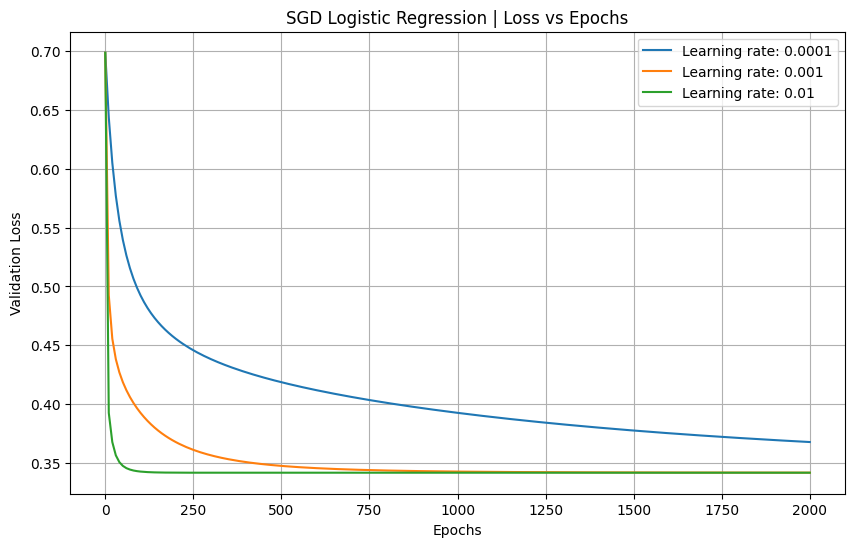

In [ ]:
learning_rates = [0.0001, 0.001, 0.01]
histories = {}

for lr in learning_rates:
    print(f"\nTraining with lr={lr}")
    model, history = fit_sgd_logreg(
        X,
        y,
        lr=lr,
        epochs=2000,
        l2=1e-5,
        report_every=10,
    )
    histories[lr] = history

plt.figure(figsize=(10, 6))
for lr, history in histories.items():
    epochs = [h[0] for h in history]
    val_loss = [h[2] for h in history]
    plt.plot(epochs, val_loss, label=f"Learning rate: {lr}")

plt.title("SGD Logistic Regression | Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## AGD

In [20]:
def fit_agd_logreg(
    X,
    y,
    lr=1e-3,
    momentum=0.9,
    batch_size=1024,
    epochs=1000,
    l2=0.0,
    val_size=0.2,
    seed=42,
    report_every=100,
):
    Xtr, Xval, ytr, yval = _train_val_split(X, y, val_size, seed)
    is_bin, mu, sd = _scale_fit(Xtr)
    Xtr = _scale_transform(Xtr, is_bin, mu, sd).to_numpy(dtype=float)
    Xval = _scale_transform(Xval, is_bin, mu, sd).to_numpy(dtype=float)
    ytr = ytr.to_numpy(dtype=float)
    yval = yval.to_numpy(dtype=float)

    n, d = Xtr.shape
    rng = np.random.default_rng(seed)
    w = rng.normal(scale=0.01, size=d)
    b = 0.0
    vw = np.zeros_like(w)
    vb = 0.0

    history = []

    # Initial loss
    p_tr = _sigmoid(Xtr @ w + b)
    p_va = _sigmoid(Xval @ w + b)
    tr_loss = _logloss(ytr, p_tr)
    va_loss = _logloss(yval, p_va)
    history.append((0, tr_loss, va_loss))
    print(f"Epoch 0 (initial): train_loss={tr_loss:.4f}, val_loss={va_loss:.4f}")

    # Training loop
    for ep in range(1, epochs + 1):
        idx = rng.permutation(n)
        for i in range(0, n, batch_size):
            j = idx[i : i + batch_size]
            xb, yb = Xtr[j], ytr[j]

            # Nesterov lookahead step
            w_look = w + momentum * vw
            b_look = b + momentum * vb

            pb = _sigmoid(xb @ w_look + b_look)

            # Gradients
            gw = (xb.T @ (pb - yb)) / len(j) + l2 * w_look
            gb = np.mean(pb - yb)

            # Update velocity
            vw = momentum * vw - lr * gw
            vb = momentum * vb - lr * gb

            # Update params
            w += vw
            b += vb

        if ep % report_every == 0:
            p_tr = _sigmoid(Xtr @ w + b)
            p_va = _sigmoid(Xval @ w + b)
            tr_loss = _logloss(ytr, p_tr)
            va_loss = _logloss(yval, p_va)
            history.append((ep, tr_loss, va_loss))
            print(f"Epoch {ep}: train_loss={tr_loss:.4f}, val_loss={va_loss:.4f}")

    model = {
        "w": w,
        "b": b,
        "is_bin": is_bin,
        "mu": mu,
        "sd": sd,
        "cols": list(X.columns),
    }
    return model, history

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import f1_score, roc_auc_score


def fit_agd_logreg(
    X,
    y,
    lr=1e-3,
    momentum=0.9,
    batch_size=1024,
    epochs=1000,
    l2=0.0,
    val_size=0.2,
    seed=42,
    report_every=100,
    tol=1e-6,
    patience=50,
):
    Xtr, Xval, ytr, yval = _train_val_split(X, y, val_size, seed)
    is_bin, mu, sd = _scale_fit(Xtr)
    Xtr = _scale_transform(Xtr, is_bin, mu, sd).to_numpy(dtype=float)
    Xval = _scale_transform(Xval, is_bin, mu, sd).to_numpy(dtype=float)
    ytr = ytr.to_numpy(dtype=float)
    yval = yval.to_numpy(dtype=float)

    n, d = Xtr.shape
    rng = np.random.default_rng(seed)
    w = rng.normal(scale=0.01, size=d)
    b = 0.0
    vw = np.zeros_like(w)
    vb = 0.0

    history = []
    best_val_loss = float("inf")
    best_state = None
    no_improve = 0

    # initial loss
    p_tr = _sigmoid(Xtr @ w + b)
    p_va = _sigmoid(Xval @ w + b)
    tr_loss = _logloss(ytr, p_tr)
    va_loss = _logloss(yval, p_va)
    history.append((0, tr_loss, va_loss))
    best_val_loss, best_state = va_loss, (w.copy(), b)
    print(f"Epoch 0: train_loss={tr_loss:.6f}, val_loss={va_loss:.6f}")

    start_time = time.time()

    for ep in range(1, epochs + 1):
        idx = rng.permutation(n)
        for i in range(0, n, batch_size):
            j = idx[i : i + batch_size]
            xb, yb = Xtr[j], ytr[j]

            # lookahead
            w_look = w + momentum * vw
            b_look = b + momentum * vb
            pb = _sigmoid(xb @ w_look + b_look)

            gw = (xb.T @ (pb - yb)) / len(j) + l2 * w_look
            gb = np.mean(pb - yb)

            vw = momentum * vw - lr * gw
            vb = momentum * vb - lr * gb
            w += vw
            b += vb

        # monitor
        if ep % report_every == 0:
            p_tr = _sigmoid(Xtr @ w + b)
            p_va = _sigmoid(Xval @ w + b)
            tr_loss = _logloss(ytr, p_tr)
            va_loss = _logloss(yval, p_va)
            history.append((ep, tr_loss, va_loss))
            print(f"Epoch {ep}: train_loss={tr_loss:.6f}, val_loss={va_loss:.6f}")

            # early stopping check
            if best_val_loss - va_loss > tol:
                best_val_loss = va_loss
                best_state = (w.copy(), b)
                no_improve = 0
            else:
                no_improve += report_every
                if no_improve >= patience:
                    print(f"Early stopping at epoch {ep} (no improvement ≥ {tol})")
                    break

    elapsed = time.time() - start_time

    # restore best state
    w, b = best_state

    # final metrics
    p_val = _sigmoid(Xval @ w + b)
    y_pred = (p_val >= 0.5).astype(int)
    f1 = f1_score(yval, y_pred)
    auc = roc_auc_score(yval, p_val)

    metrics = {
        "best_val_loss": best_val_loss,
        "f1": f1,
        "auc": auc,
        "time_sec": elapsed,
    }

    model = {
        "w": w,
        "b": b,
        "is_bin": is_bin,
        "mu": mu,
        "sd": sd,
        "cols": list(X.columns),
    }
    return model, history, metrics


Training with lr=0.0001
Epoch 0 (initial): train_loss=0.6985, val_loss=0.6986
Epoch 10: train_loss=0.4964, val_loss=0.4924
Epoch 20: train_loss=0.4604, val_loss=0.4556
Epoch 30: train_loss=0.4435, val_loss=0.4382
Epoch 40: train_loss=0.4326, val_loss=0.4270
Epoch 50: train_loss=0.4243, val_loss=0.4186
Epoch 60: train_loss=0.4176, val_loss=0.4118
Epoch 70: train_loss=0.4118, val_loss=0.4060
Epoch 80: train_loss=0.4068, val_loss=0.4010
Epoch 90: train_loss=0.4023, val_loss=0.3966
Epoch 100: train_loss=0.3983, val_loss=0.3926
Epoch 110: train_loss=0.3947, val_loss=0.3890
Epoch 120: train_loss=0.3914, val_loss=0.3857
Epoch 130: train_loss=0.3884, val_loss=0.3828
Epoch 140: train_loss=0.3856, val_loss=0.3800
Epoch 150: train_loss=0.3831, val_loss=0.3775
Epoch 160: train_loss=0.3807, val_loss=0.3753
Epoch 170: train_loss=0.3786, val_loss=0.3732
Epoch 180: train_loss=0.3766, val_loss=0.3712
Epoch 190: train_loss=0.3748, val_loss=0.3694
Epoch 200: train_loss=0.3731, val_loss=0.3678
Epoch 210:

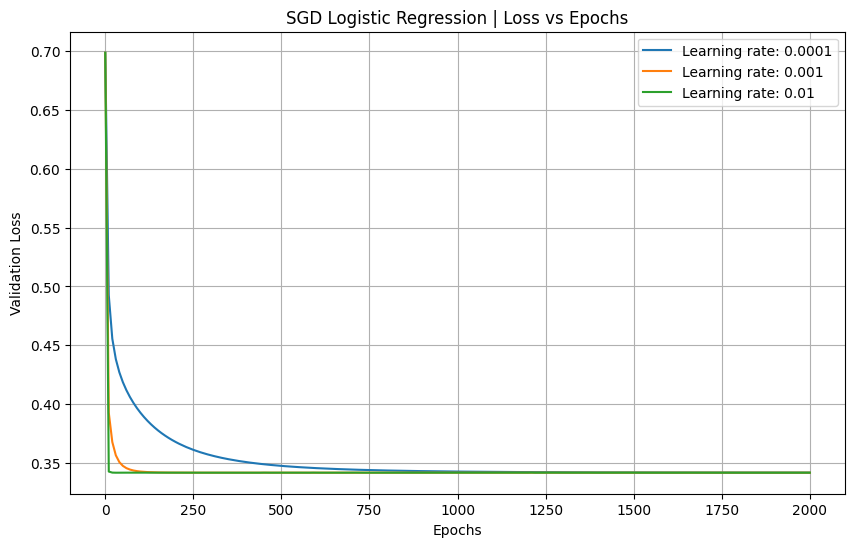

In [21]:
learning_rates = [0.0001, 0.001, 0.01]
histories = {}

for lr in learning_rates:
    print(f"\nTraining with lr={lr}")
    model, history = fit_agd_logreg(
        X,
        y,
        lr=lr,
        epochs=2000,
        l2=1e-5,
        report_every=10,
    )
    histories[lr] = history

plt.figure(figsize=(10, 6))
for lr, history in histories.items():
    epochs = [h[0] for h in history]
    val_loss = [h[2] for h in history]
    plt.plot(epochs, val_loss, label=f"Learning rate: {lr}")

plt.title("SGD Logistic Regression | Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import f1_score, roc_auc_score


def fit_agd_logreg(
    X,
    y,
    lr=1e-3,
    momentum=0.9,
    batch_size=1024,
    epochs=1000,
    l2=0.0,
    val_size=0.2,
    seed=42,
    report_every=100,
    tol=1e-6,
    patience=50,
):
    Xtr, Xval, ytr, yval = _train_val_split(X, y, val_size, seed)
    is_bin, mu, sd = _scale_fit(Xtr)
    Xtr = _scale_transform(Xtr, is_bin, mu, sd).to_numpy(dtype=float)
    Xval = _scale_transform(Xval, is_bin, mu, sd).to_numpy(dtype=float)
    ytr = ytr.to_numpy(dtype=float)
    yval = yval.to_numpy(dtype=float)

    n, d = Xtr.shape
    rng = np.random.default_rng(seed)
    w = rng.normal(scale=0.01, size=d)
    b = 0.0
    vw = np.zeros_like(w)
    vb = 0.0

    history = []
    best_val_loss = float("inf")
    best_state = None
    no_improve = 0

    # initial loss
    p_tr = _sigmoid(Xtr @ w + b)
    p_va = _sigmoid(Xval @ w + b)
    tr_loss = _logloss(ytr, p_tr)
    va_loss = _logloss(yval, p_va)
    history.append((0, tr_loss, va_loss))
    best_val_loss, best_state = va_loss, (w.copy(), b)
    print(f"Epoch 0: train_loss={tr_loss:.6f}, val_loss={va_loss:.6f}")

    start_time = time.time()

    for ep in range(1, epochs + 1):
        idx = rng.permutation(n)
        for i in range(0, n, batch_size):
            j = idx[i : i + batch_size]
            xb, yb = Xtr[j], ytr[j]

            # lookahead
            w_look = w + momentum * vw
            b_look = b + momentum * vb
            pb = _sigmoid(xb @ w_look + b_look)

            gw = (xb.T @ (pb - yb)) / len(j) + l2 * w_look
            gb = np.mean(pb - yb)

            vw = momentum * vw - lr * gw
            vb = momentum * vb - lr * gb
            w += vw
            b += vb

        # monitor
        if ep % report_every == 0:
            p_tr = _sigmoid(Xtr @ w + b)
            p_va = _sigmoid(Xval @ w + b)
            tr_loss = _logloss(ytr, p_tr)
            va_loss = _logloss(yval, p_va)
            history.append((ep, tr_loss, va_loss))
            print(f"Epoch {ep}: train_loss={tr_loss:.6f}, val_loss={va_loss:.6f}")

            # early stopping check
            if best_val_loss - va_loss > tol:
                best_val_loss = va_loss
                best_state = (w.copy(), b)
                no_improve = 0
            else:
                no_improve += report_every
                if no_improve >= patience:
                    print(f"Early stopping at epoch {ep} (no improvement ≥ {tol})")
                    break

    elapsed = time.time() - start_time

    # restore best state
    w, b = best_state

    # final metrics
    p_val = _sigmoid(Xval @ w + b)
    y_pred = (p_val >= 0.5).astype(int)
    f1 = f1_score(yval, y_pred)
    auc = roc_auc_score(yval, p_val)

    metrics = {
        "best_val_loss": best_val_loss,
        "f1": f1,
        "auc": auc,
        "time_sec": elapsed,
    }

    model = {
        "w": w,
        "b": b,
        "is_bin": is_bin,
        "mu": mu,
        "sd": sd,
        "cols": list(X.columns),
    }
    return model, history, metrics

In [30]:
learning_rates = [0.0001, 0.001, 0.01]
results = {}

for lr in learning_rates:
    print(f"\n=== Training with lr={lr} ===")
    model, history, metrics = fit_agd_logreg(
        X,
        y,
        lr=lr,
        momentum=0.9,
        batch_size=32,
        epochs=2000,
        report_every=10,
        tol=1e-6,
        patience=200,
    )
    results[lr] = {"history": history, "metrics": metrics}

# summarize
for lr, res in results.items():
    print(
        f"LR={lr} | best_val_loss={res['metrics']['best_val_loss']:.6f} "
        f"| F1={res['metrics']['f1']:.4f} | AUC={res['metrics']['auc']:.4f} "
        f"| time={res['metrics']['time_sec']:.2f}s"
    )


=== Training with lr=0.0001 ===
Epoch 0: train_loss=0.698514, val_loss=0.698574
Epoch 10: train_loss=0.360205, val_loss=0.355141
Epoch 20: train_loss=0.349761, val_loss=0.345053
Epoch 30: train_loss=0.347328, val_loss=0.342784
Epoch 40: train_loss=0.346521, val_loss=0.342095
Epoch 50: train_loss=0.346202, val_loss=0.341841
Epoch 60: train_loss=0.346060, val_loss=0.341741
Epoch 70: train_loss=0.345989, val_loss=0.341692
Epoch 80: train_loss=0.345952, val_loss=0.341690
Epoch 90: train_loss=0.345930, val_loss=0.341670
Epoch 100: train_loss=0.345918, val_loss=0.341680
Epoch 110: train_loss=0.345910, val_loss=0.341672
Epoch 120: train_loss=0.345906, val_loss=0.341682
Epoch 130: train_loss=0.345903, val_loss=0.341670
Epoch 140: train_loss=0.345901, val_loss=0.341674
Epoch 150: train_loss=0.345899, val_loss=0.341678
Epoch 160: train_loss=0.345899, val_loss=0.341684
Epoch 170: train_loss=0.345898, val_loss=0.341681
Epoch 180: train_loss=0.345898, val_loss=0.341682
Epoch 190: train_loss=0.3458

In [ ]:
def plot_val_loss(results, title="Validation Loss vs Epochs"):
    plt.figure(figsize=(9, 6))
    for lr, res in results.items():
        hist = np.array(res["history"])
        epochs, va_loss = hist[:, 0], hist[:, 2]
        plt.plot(epochs, va_loss, label=f"LR={lr}")

    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

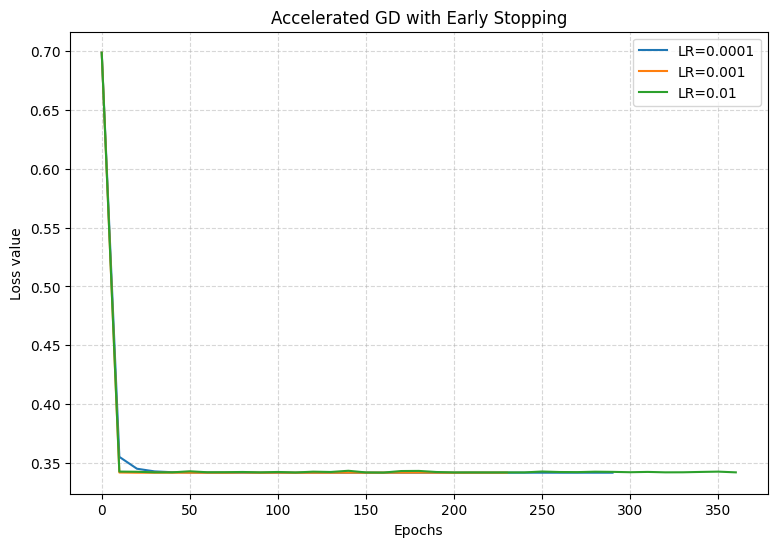

In [31]:
plot_val_loss(results, title="Accelerated GD with Early Stopping")